In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import lightgbm as lgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

# data_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))), 'user_data')
# model_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'models')
# output_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))), 'prediction_result')

# data_path = os.path.join(data_dir, 'train_tree.csv')
# test_data_path = os.path.join(data_dir, 'test_tree.csv')
# model_path = os.path.join(model_dir, 'xgb.pkl')
# output_path = os.path.join(output_dir, 'xgb.csv')
data_path = './user_data/train_tree.csv'
test_data_path = './user_data/test_tree.csv'
model_path = './model/lgb.pkl'
output_path = './prediction_result/lgb.csv'

In [2]:
df_train = pd.read_csv(data_path)
df_test = pd.read_csv(test_data_path)
print(df_train.shape)
print(df_test.shape)
y = df_train.pop('price').values
X = df_train.values
X_test = df_test.values

(150000, 725)
(50000, 724)


In [3]:
def my_score(y_predict, label):
    '''
    自定义评估指标
    :return:
    '''
    label = label.get_label()
    score = mean_absolute_error(np.exp(label), np.exp(y_predict))
    return 'exp_score', score, False

## 贝叶斯调参

In [4]:
# def lgb_cv( min_child_weight, max_depth, feature_fraction, bagging_fraction):
#     param = {
#         'boosting':'gbdt',
#         'objective': 'regression_l1',
#         'seed': 2020,
#         'num_iterations':100,
# #         "early_stopping_rounds": 5,
#         'learning_rate':0.3,
        
#     }
# #     param['learning_rate'] = float(learning_rate)
#     param['min_child_weight'] = float(min_child_weight)
#     param['max_depth'] = int(max_depth)
#     param['num_leaves'] = 31
#     param['feature_fraction'] = float(feature_fraction)
#     param['bagging_fraction'] = float(bagging_fraction)
#     data = lgb.Dataset(data=X,label=y, silent=True)
#     cv_result = lgb.cv(params=param,train_set=data, nfold=5,feval=my_score,stratified=False)
#     return -np.mean(cv_result['exp_score-mean'])


# lgb_bo = BayesianOptimization(
#     lgb_cv,
#     {
# #         'learning_rate': (0.03, 0.3),
#         'max_depth': (4, 10),
#         'feature_fraction':(0.3,1),
#         'bagging_fraction':(0.5,1),
#         'min_child_weight': (10, 200)
#      }
# )
# lgb_bo.maximize()
# # print(lgb_bo.res)
# # print(lgb_bo.max['params'])

## 使用最佳参数进行训练

In [5]:
from sklearn.model_selection import KFold

param = {'boosting_type': 'gbdt',
         'num_leaves': 31,
         'max_depth': 8,
         "lambda_l2": 2,  # 防止过拟合
         'min_data_in_leaf': 20,  # 防止过拟合，好像都不用怎么调
         'objective': 'regression_l1',
         'learning_rate': 0.03,
#          "min_child_samples": 20,

         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 2020,
         "metric": 'mae',
         }

folds = KFold(n_splits=5, shuffle=True, random_state=2020)
oof_lgb = np.zeros(len(X))
predictions_lgb = np.zeros(len(X_test))
predictions_train_lgb = np.zeros(len(X))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
    val_data = lgb.Dataset(X[val_idx], y[val_idx])

    num_round = 50000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[val_data], verbose_eval=100,
                    early_stopping_rounds=50, feval = my_score)
    # 预测验证集
    oof_lgb[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)
    # 预测测试集
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
    # 预测完整的测试集(包含验证集)
    predictions_train_lgb += clf.predict(X, num_iteration=clf.best_iteration) / folds.n_splits

fold n°1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68326
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 706
[LightGBM] [Info] Start training from score 8.086000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.195657	valid_0's exp_score: 1140.48
[200]	valid_0's l1: 0.143964	valid_0's exp_score: 696.842
[300]	valid_0's l1: 0.132348	valid_0's exp_score: 607.532
[400]	valid_0's l1: 0.127106	valid_0's exp_score: 574.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's l1: 0.124168	valid_0's exp_score: 554.527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's l1: 0.122345	valid_0's exp_score: 542.336
[700]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	valid_0's l1: 0.112705	valid_0's exp_score: 481.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3700]	valid_0's l1: 0.112641	valid_0's exp_score: 481.014
[3800]	valid_0's l1: 0.112579	valid_0's exp_score: 480.822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3900]	valid_0's l1: 0.112527	valid_0's exp_score: 480.584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[500]	valid_0's l1: 0.122817	valid_0's exp_score: 544.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's l1: 0.120966	valid_0's exp_score: 531.403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's l1: 0.119459	valid_0's exp_score: 521.731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's l1: 0.118297	valid_0's exp_score: 514.488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l1: 0.117409	valid_0's exp_score: 508.968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 0.116655	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4300]	valid_0's l1: 0.110854	valid_0's exp_score: 470.218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4400]	valid_0's l1: 0.11081	valid_0's exp_score: 469.961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4500]	valid_0's l1: 0.110761	valid_0's exp_score: 469.662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6400]	valid_0's l1: 0.110138	valid_0's exp_score: 466.372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6500]	valid_0's l1: 0.110111	valid_0's exp_score: 466.253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6600]	valid_0's l1: 0.110082	valid_0's exp_score: 466.13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6700]	valid_0's l1: 0.110047	valid_0's exp_score: 465.957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's l1: 0.111185	valid_0's exp_score: 489.255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3500]	valid_0's l1: 0.111124	valid_0's exp_score: 488.881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	valid_0's l1: 0.111064	valid_0's exp_score: 488.43

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5200]	valid_0's l1: 0.110278	valid_0's exp_score: 483.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7100]	valid_0's l1: 0.109734	valid_0's exp_score: 480.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7200]	valid_0's l1: 0.109723	valid_0's exp_score: 480.462
[7300]	valid_0's l1: 0.109715	valid_0's exp_score: 480.395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3600]	valid_0's l1: 0.111215	valid_0's exp_score: 487.918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3700]	valid_0's l1: 0.111144	valid_0's exp_score: 487.547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[5400]	valid_0's l1: 0.110399	valid_0's exp_score: 483.663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5500]	valid_0's l1: 0.110363	valid_0's exp_score: 483.467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5600]	valid_0's l1: 0.110328	valid_0's exp_score: 483.316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5700]	valid_0's l1: 0.110313	valid_0's exp_score: 483.235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Info] Start training from score 8.086000
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.19066	valid_0's exp_score: 1117.67
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's l1: 0.141846	valid_0's exp_score: 686.404
[300]	valid_0's l1: 0.130526	valid_0's exp_score: 594.878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's l1: 0.125352	valid_0's exp_score: 561.217
[500]	valid_0's l1: 0.122246	valid_0's exp_score: 539.478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's l1: 0.12014	valid_0's exp_score: 524.415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's l1: 0.118435	valid_0's exp_score: 514.386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5100]	valid_0's l1: 0.110155	valid_0's exp_score: 466.959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [8]:
print("lgb score: {:<8.8f}".format(mean_absolute_error(np.exp(oof_lgb), np.exp(y))))

# 验证集输出
SaleID = range(150000)
y_true = y
y_predict = oof_lgb
df = pd.DataFrame({'SaleID':SaleID,'y_true':y_true,'y_predict':y_predict})
df.to_csv('./prediction_result/lgb_valid.csv',index=False)

lgb score: 474.05584526


In [9]:
# 测试集输出
saleID = np.array(range(200000, 250000))
price = np.exp(predictions_lgb)
df = pd.DataFrame({'SaleID':saleID,'price':price})
df.to_csv('./prediction_result/lgb_test.csv',index=False)

In [10]:
df.describe()

,SaleID,price
count,50000.000000,50000.000000
mean,224999.500000,5693.787485
std,14433.901067,6687.796002
min,200000.000000,16.361217
25%,212499.750000,1332.837732
50%,224999.500000,3210.707048
75%,237499.250000,7567.054201
max,249999.000000,84086.523370


In [11]:
clf.feature_importance()

array([1351,  479, 5003,   39, 2051,  205,  272,  122,  189,  123,  426,
        251,  281,  526,  180,  164,  104,  168,  151,  208, 4857, 5707,
       2573, 1945,  685,  709,  858,  544,  168,   77,  658, 3341, 3025,
       4213, 1409, 2605, 1408, 3105, 2323, 2433, 2008, 2087, 1285, 2494,
        539, 2008, 2271, 2230, 1518, 2171,  583,   61, 1944,  353, 1139,
       1924, 1999, 1522, 1682, 2348,  580, 1881, 1380, 2567, 2444, 2358,
       1831, 1765, 1277, 2315,    2, 1541, 2176, 1466, 1477, 2193,  207,
          0, 1972,  106,  970, 2009,  696,  701, 1175,  407, 1351,  414,
       1191,  191,  307,   95,  370,  107,  365,   24,  320, 1116,  707,
        711, 1192,   14,  403,  299,  190,  239,  353,  654,  465,  401,
        146,  291,  224,  624,    0,   80,  584,  281,  279,  589,  646,
        506,  710,  414,  197,  801,    0,    0,  540,   23,  105,  676,
        196,   77,  200,   50,   53,   51,  398,    6,    0,   23,   73,
        134,   18,    0,    2,    0,    0,  130,   

In [12]:
# clf.importance_type='gain'
im = pd.DataFrame({'feature':df_train.columns,'importance':clf.feature_importance()})
im=im.sort_values('importance',ascending=False)
im.head(50)

,feature,importance
21,used_years,5707
2,power,5003
20,used_days,4857
33,regionCode_price_max,4213
31,region_count,3341
37,regionCode_price_std,3105
32,regionCode_price_min,3025
35,regionCode_price_median,2605
22,kilometer_div_years,2573
63,city_price_std,2567


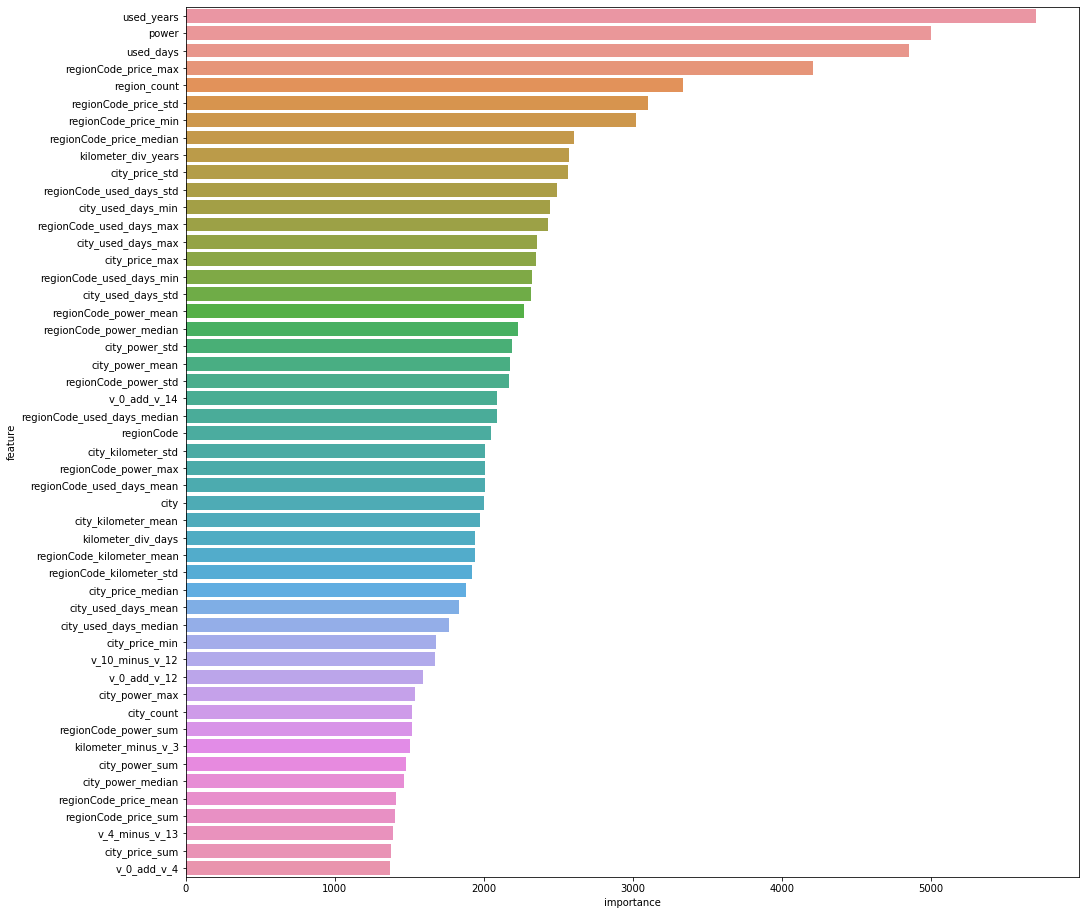

In [13]:
import seaborn as sns
f, ax = plt.subplots(figsize=(16, 16))
sns.barplot(y='feature',x='importance',data=im.head(50))